In [0]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
def get_generator(input_layer, condition_layer):

  merged_input = Concatenate()([input_layer, condition_layer])
  
  hid = Dense(128 * 8 * 8, activation='relu')(merged_input)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((8, 8, 128))(hid)

  hid = Conv2D(128, kernel_size=4, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  # hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  # hid = BatchNormalization(momentum=0.9)(hid)
  # hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  
  return model, out


In [0]:
def get_discriminator(input_layer, condition_layer):
  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  
  merged_layer = Concatenate()([hid, condition_layer])
  hid = Dense(512, activation='relu')(merged_layer)
  #hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)

  model.summary()

  return model, out

In [0]:
from keras.preprocessing import image

def one_hot_encode(y):
  z = np.zeros((len(y), 10))
  idx = np.arange(len(y))
  z[idx, y] = 1
  return z

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def generate_random_labels(n):
  y = np.random.choice(10, n)
  y = one_hot_encode(y)
  return y

tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
  
def show_samples(batchidx):
  fig, axs = plt.subplots(5, 6, figsize=(10,6))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)
  #fig, axs = plt.subplots(5, 6)
  #fig.tight_layout()
  for classlabel in range(10):
    row = int(classlabel / 2)
    coloffset = (classlabel % 2) * 3
    lbls = one_hot_encode([classlabel] * 3)
    noise = generate_noise(3, 100)
    gen_imgs = generator.predict([noise, lbls])

    for i in range(3):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[row,i+coloffset].imshow(img)
        axs[row,i+coloffset].axis('off')
        if i ==1:
          axs[row,i+coloffset].set_title(tags[classlabel])
  plt.show()
  plt.close()  

In [0]:
# GAN creation
img_input = Input(shape=(32,32,3))
disc_condition_input = Input(shape=(10,))

discriminator, disc_out = get_discriminator(img_input, disc_condition_input)
discriminator.compile(optimizer=Adam(0.001, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
gen_condition_input = Input(shape=(10,))
generator, gen_out = get_generator(noise_input, gen_condition_input)

gan_input = Input(shape=(100,))
x = generator([gan_input, gen_condition_input])
gan_out = discriminator([x, disc_condition_input])
gan = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.001, 0.5), loss='binary_crossentropy')

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 32, 32, 128)  3584        input_31[0][0]                   
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 32, 32, 128)  512         conv2d_55[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_67 (LeakyReLU)      (None, 32, 32, 128)  0           batch_normalization_67[0][0]     
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  app.launch_new_instance()


In [0]:
BATCH_SIZE = 16

# # Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()
X_train = X_train[:25000]
y_train = y_train[:25000]

# Normalize data
X_train = (X_train - 127.5) / 127.5

# 1hot encode labels
y_train = one_hot_encode(y_train[:,0])

print ("Training shape: {}, {}".format(X_train.shape, y_train.shape))
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

print ("Num batches: {}".format(num_batches))

Training shape: (25000, 32, 32, 3), (25000, 10)
Num batches: 1562


In [0]:
# Array to store samples for experience replay
exp_replay = []

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 0.67064774 10.309841 0.07676813 Cumu: 5.490244388580322 0.07676813006401062
500 0.47935894 0.22651796 1.1052563 Cumu: 0.42010467590210204 1.8644153424520082
1000 0.31755438 0.16870168 1.8482654 Cumu: 0.4074794529201268 1.8613741026589317
1500 1.1076108 0.23827308 1.3137108 Cumu: 0.41790279462129415 1.8143618964673276
	Epoch: 1, Generator Loss: 1.806304860731024, Discriminator Loss: [0.42244822 0.        ]


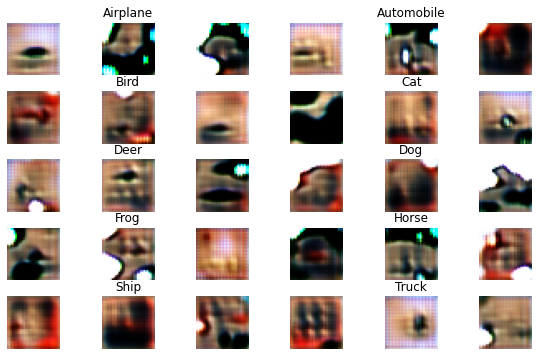

0 0.33302462 0.3132716 1.5131481 Cumu: 0.32314813137054443 1.5131480693817139
500 0.4257406 0.376817 1.5002831 Cumu: 0.4687733298052333 1.58506778721324
1000 0.31658822 0.32362893 0.42284924 Cumu: 0.49314113620754246 1.4315096306485253
1500 0.40104306 0.38410872 0.6412164 Cumu: 0.49235511286746336 1.3490917772268114
	Epoch: 2, Generator Loss: 1.347683743422281, Discriminator Loss: [0.4886578 0.       ]


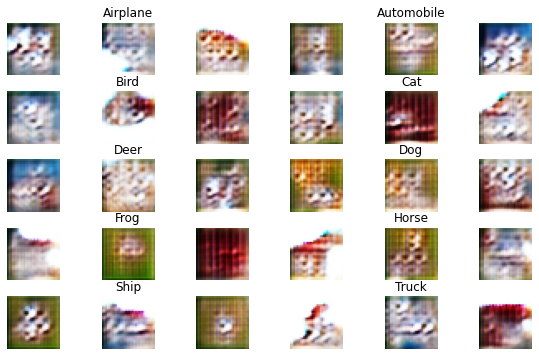

0 0.21677852 0.31129748 0.8294246 Cumu: 0.26403799653053284 0.8294246196746826
500 1.3230091 0.4375236 0.9157002 Cumu: 0.4628402801330932 1.3407074685195486
1000 0.29815525 0.51685953 2.623717 Cumu: 0.4373616800679789 1.418057529811192
1500 0.72643495 0.23423682 1.9117078 Cumu: 0.4450933264542388 1.4161876818204893
	Epoch: 3, Generator Loss: 1.4216070972715722, Discriminator Loss: [0.44107422 0.        ]


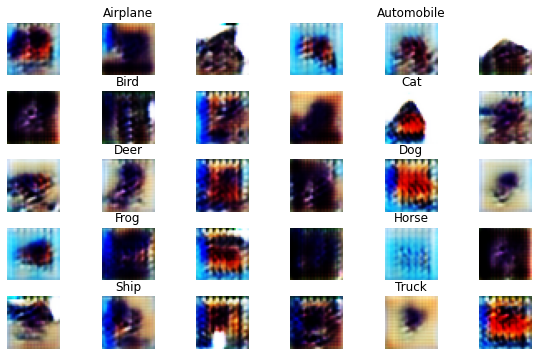

0 0.2766791 0.65430874 1.3429205 Cumu: 0.46549391746520996 1.3429205417633057
500 0.7253967 0.6897289 1.3397708 Cumu: 0.4222962156741205 1.6050109478111514
1000 0.4070282 0.29745752 2.010972 Cumu: 0.39967814168253624 1.6340521267958574
1500 0.19501455 0.35232013 0.3477249 Cumu: 0.390944082525712 1.6421155290880416
	Epoch: 4, Generator Loss: 1.6439684963190067, Discriminator Loss: [0.3906614 0.       ]


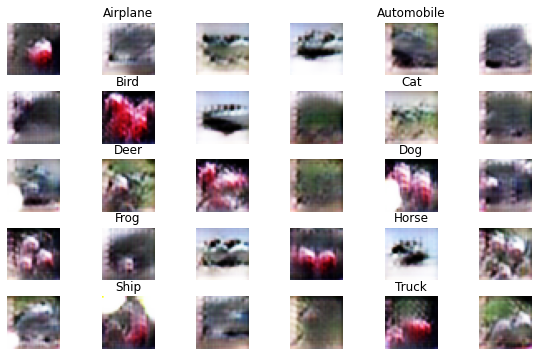

0 0.2802171 0.7204819 2.3135881 Cumu: 0.5003495216369629 2.3135881423950195
500 0.55915225 0.2626587 1.6897882 Cumu: 0.37188946082444485 1.7908677005779718
1000 0.5858429 0.27217266 1.9809257 Cumu: 0.3690201400162338 1.8708192842019784
1500 0.48124808 0.35996324 0.61401284 Cumu: 0.37690180829967523 1.834194461498
	Epoch: 5, Generator Loss: 1.817430290709537, Discriminator Loss: [0.38075173 0.        ]


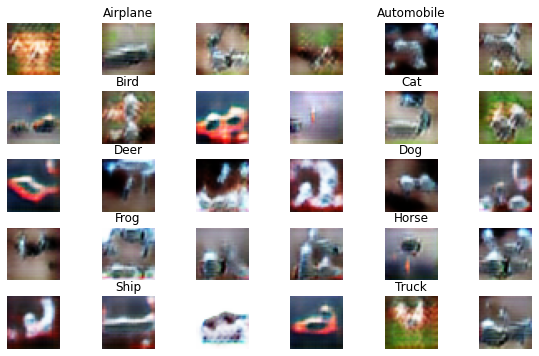

0 0.31903696 0.26829338 1.8994771 Cumu: 0.29366517066955566 1.8994771242141724
500 0.44861466 0.28622687 1.6130899 Cumu: 0.49856549108813625 1.4349879778906733
1000 0.3468586 0.24870674 1.5158284 Cumu: 0.4706468458299513 1.5692731002113083
1500 0.19675937 0.26599228 1.6203787 Cumu: 0.4418691982038016 1.6647981359889554
	Epoch: 6, Generator Loss: 1.6779853608387685, Discriminator Loss: [0.43955928 0.        ]


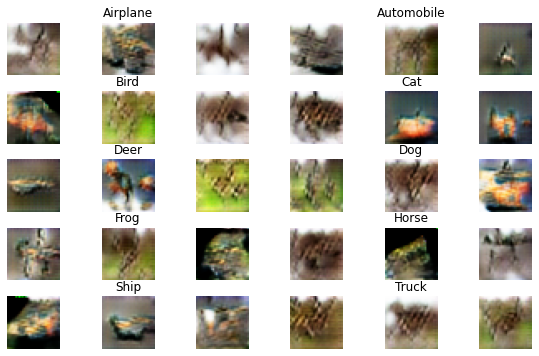

0 0.5127261 0.30521336 1.9682708 Cumu: 0.4089697599411011 1.9682707786560059
500 0.25798994 0.5661799 2.2615657 Cumu: 0.4345490842046376 1.6418532822541372
1000 0.24743098 0.23344272 2.5031562 Cumu: 0.3887699824589473 1.892024444979983
1500 0.35912055 0.28735852 2.2418025 Cumu: 0.40784699848538475 1.796472423756464
	Epoch: 7, Generator Loss: 1.7986468138619207, Discriminator Loss: [0.40789595 0.        ]


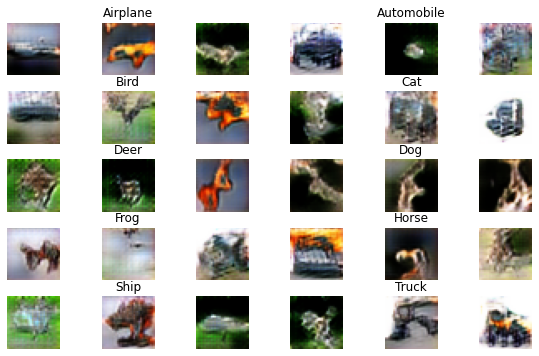

0 0.30843586 0.48863143 1.8951875 Cumu: 0.3985336422920227 1.895187497138977
500 0.47355786 0.6718786 2.211048 Cumu: 0.46758850463136226 1.6162803977906346
1000 0.45958278 0.42234647 1.399798 Cumu: 0.4505360362293956 1.6929623113347814
1500 0.23779052 0.28161514 1.8077052 Cumu: 0.45330863408769156 1.6928413572270102
	Epoch: 8, Generator Loss: 1.6953319628626375, Discriminator Loss: [0.45240587 0.        ]


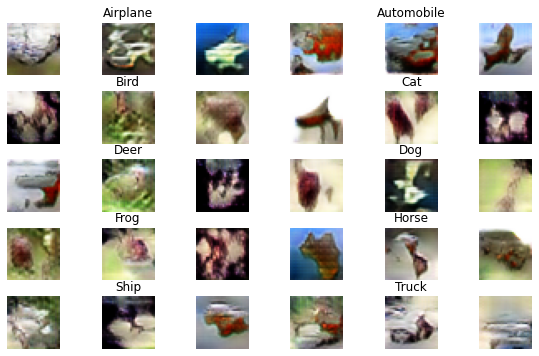

0 1.3971883 0.23904869 2.1184595 Cumu: 0.8181185126304626 2.118459463119507
500 0.9908666 0.68999183 1.9533579 Cumu: 0.4369018311034182 1.8219669859804317
1000 0.6169491 0.28043258 0.66966736 Cumu: 0.4166469821682224 1.8999357972588096
1500 0.4006679 0.5410494 1.5770352 Cumu: 0.4141170290769695 1.9227418876107258
	Epoch: 9, Generator Loss: 1.9212606828588223, Discriminator Loss: [0.4144081 0.       ]


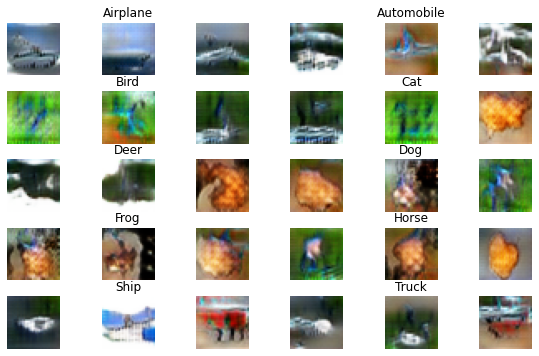

0 0.49771377 0.24604367 1.163392 Cumu: 0.3718787133693695 1.1633919477462769
500 0.6029587 0.37484747 1.6817517 Cumu: 0.41840997570289107 1.823852277325537
1000 0.3031522 0.25604904 2.7196894 Cumu: 0.4234986510071959 1.8687289717433218
1500 0.23337752 0.30149174 1.4756472 Cumu: 0.4095626109286517 1.9490558343240216
	Epoch: 10, Generator Loss: 1.9509020922622058, Discriminator Loss: [0.410178 0.      ]


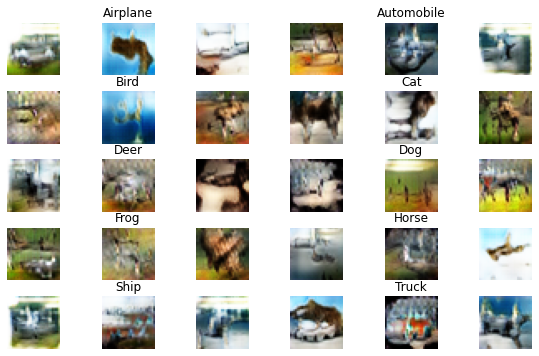

0 0.256716 0.37497234 1.8938451 Cumu: 0.31584417819976807 1.8938450813293457
500 0.4492163 0.2588902 1.909729 Cumu: 0.4290063062351859 1.9767364461026982
1000 0.45404628 0.24613366 1.4694973 Cumu: 0.4208492923092532 2.0356455487566634
1500 0.25494558 0.35091528 2.1206477 Cumu: 0.4233476917081321 2.0212576454834172
	Epoch: 11, Generator Loss: 2.022103430252527, Discriminator Loss: [0.4223346 0.       ]


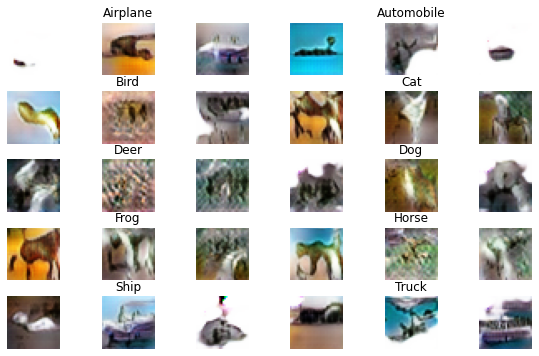

0 0.48305264 0.5547657 1.4323382 Cumu: 0.5189091563224792 1.4323382377624512
500 0.25841737 0.33288035 2.665 Cumu: 0.4056437905439122 2.041641597976228
1000 0.5582087 0.72275454 1.9256352 Cumu: 0.4082913546414523 2.0664039288724694
1500 0.2764782 0.21069017 2.26059 Cumu: 0.40726096339419554 2.068974017818954
	Epoch: 12, Generator Loss: 2.076996620691998, Discriminator Loss: [0.40608904 0.        ]


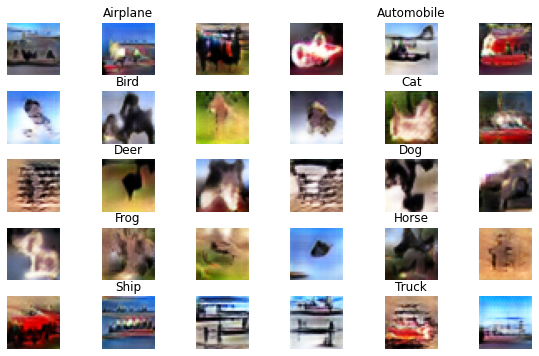

0 0.39874527 0.28987724 2.0959513 Cumu: 0.3443112373352051 2.0959513187408447
500 0.46386588 0.236406 3.1420097 Cumu: 0.3952218244175711 2.1710317166979443
1000 0.20573512 0.26093867 2.29387 Cumu: 0.39479624379526723 2.1813153497108093
1500 0.27294576 0.25725287 2.3642378 Cumu: 0.39255665493837444 2.1933436367132124
	Epoch: 13, Generator Loss: 2.1959363150001336, Discriminator Loss: [0.3910092 0.       ]


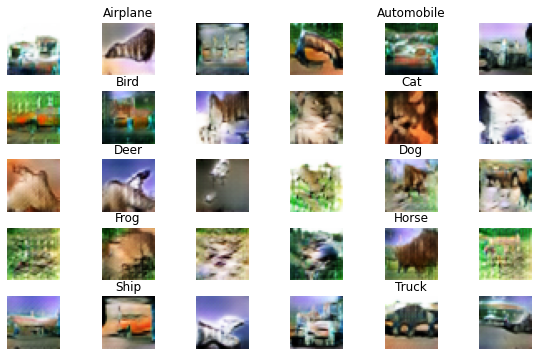

0 0.3594897 0.31565112 3.0641468 Cumu: 0.3375704288482666 3.0641467571258545
500 0.39609444 0.4241354 3.024747 Cumu: 0.38616038796430574 2.2769972633220954
1000 0.5475878 0.5760823 2.929904 Cumu: 0.38229303045587226 2.2862768794273163
1500 0.34481615 0.24114242 2.2124827 Cumu: 0.38033966125447616 2.2626689871416974
	Epoch: 14, Generator Loss: 2.259980163981759, Discriminator Loss: [0.38038406 0.        ]


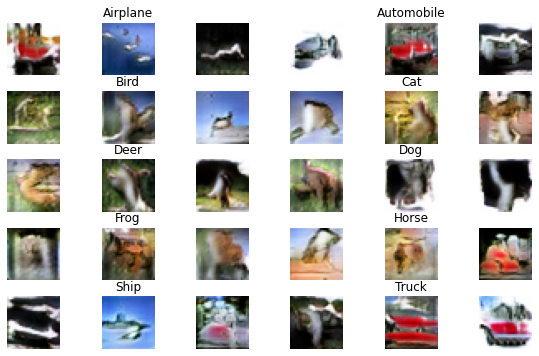

0 0.28030828 0.29834068 2.6073244 Cumu: 0.28932446241378784 2.6073243618011475
500 0.30206677 0.25299084 2.8774614 Cumu: 0.38766972890157186 2.22923120541011
1000 0.23525536 0.21161371 2.8106627 Cumu: 0.37195098602569304 2.3086079493626492
1500 0.24561267 0.26179397 2.7556458 Cumu: 0.37398078201771734 2.2904691740245045
	Epoch: 15, Generator Loss: 2.2909675743073112, Discriminator Loss: [0.3735586 0.       ]


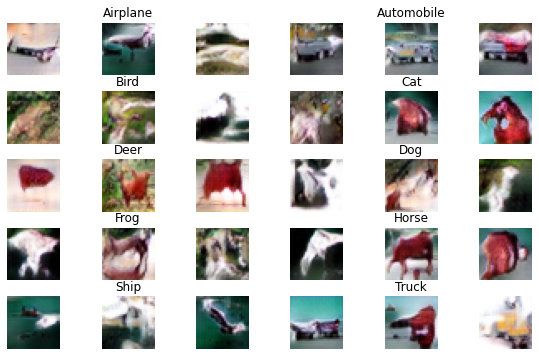

0 0.26054698 0.44773394 2.1218982 Cumu: 0.3541404604911804 2.1218981742858887
500 0.21632591 0.1875738 3.545011 Cumu: 0.3736936527335953 2.3249976667101513
1000 0.5533926 0.44810554 1.7595019 Cumu: 0.37496875073169017 2.32479237706273
1500 0.27799505 0.21694282 3.491663 Cumu: 0.37581325991006 2.3341445036922432
	Epoch: 16, Generator Loss: 2.339596930027924, Discriminator Loss: [0.37525183 0.        ]


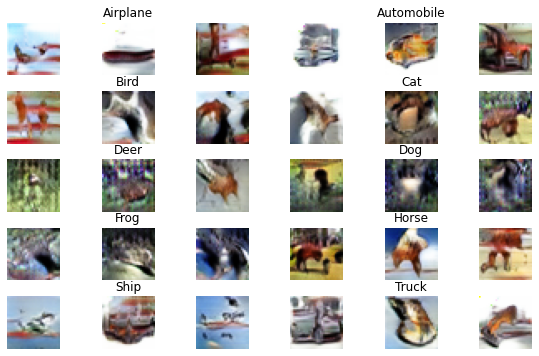

0 0.2979566 0.24834871 2.5194292 Cumu: 0.2731526494026184 2.5194292068481445
500 0.6195806 0.28116035 2.218021 Cumu: 0.3825257505009512 2.278374305623258
1000 0.32311141 0.32115817 2.6625245 Cumu: 0.37631185952719154 2.3435380106920247
1500 0.30132955 0.22044663 1.652323 Cumu: 0.3695758410408686 2.3651518933301285
	Epoch: 17, Generator Loss: 2.373128849817452, Discriminator Loss: [0.36806837 0.        ]


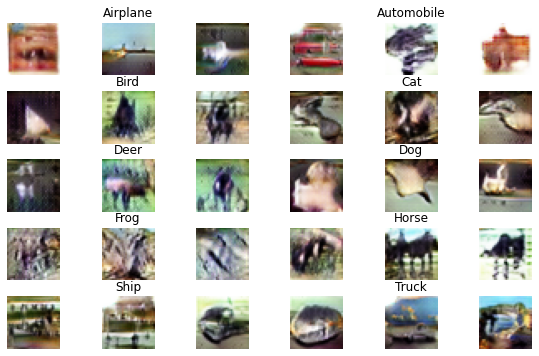

0 0.40985703 0.31855357 3.2229156 Cumu: 0.3642053008079529 3.2229156494140625
500 0.36965597 0.22759706 2.270666 Cumu: 0.3628441664035211 2.4747364420495823
1000 0.3570513 0.2380991 2.2751634 Cumu: 0.3587103204412775 2.496632227322438
1500 0.39560217 0.27917424 2.7924843 Cumu: 0.3597973665342896 2.485738342658906
	Epoch: 18, Generator Loss: 2.490049401085905, Discriminator Loss: [0.35945347 0.        ]


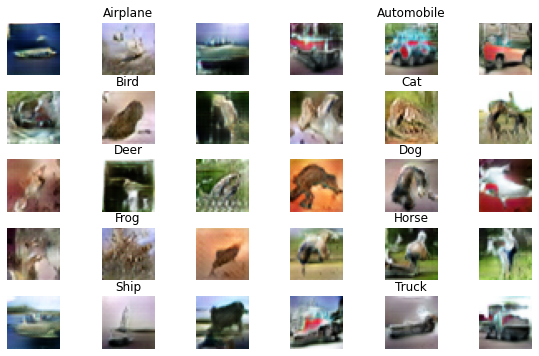

0 0.27304205 0.32084274 3.0905552 Cumu: 0.29694241285324097 3.090555191040039
500 0.5471368 0.21742448 2.9272177 Cumu: 0.3563873230102295 2.4781273916333975
1000 0.81706667 0.51176834 1.2452676 Cumu: 0.3483725746909341 2.5340574332526873
1500 0.277744 0.29441154 2.192334 Cumu: 0.3528337472284102 2.506847624378471
	Epoch: 19, Generator Loss: 2.5016072245169236, Discriminator Loss: [0.35223097 0.        ]


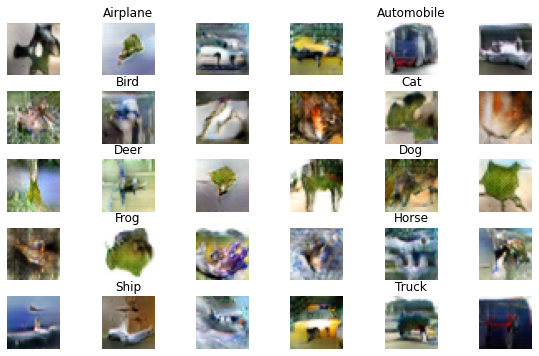

0 0.31398302 0.21895707 2.6883411 Cumu: 0.2664700448513031 2.6883411407470703
500 0.2168567 0.22434224 2.1509042 Cumu: 0.3446656491704092 2.5521379455834805
1000 0.55453956 0.43236542 2.4221568 Cumu: 0.33924193482298953 2.5699121170229726
1500 0.22696823 0.23557886 2.296434 Cumu: 0.338230079686459 2.5729597079444138
	Epoch: 20, Generator Loss: 2.5713870628008313, Discriminator Loss: [0.3381522 0.       ]


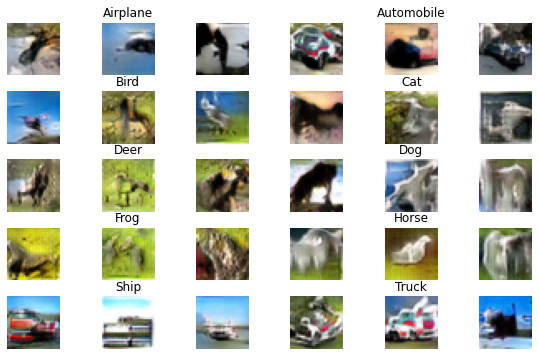

In [0]:
N_EPOCHS = 20
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    # We use same labels for generated images as in the real training batch
    generated_images = generator.predict([noise_data, labels])

    # Train on soft targets (add noise to targets as well)
    noise_prop = 0.05 # Randomly flip 5% of targets
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch([images, labels], true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
    
    # Store a random point for experience replay
    r_idx = np.random.randint(BATCH_SIZE)
    exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    
    # If we have enough points, do experience replay
    if len(exp_replay) == BATCH_SIZE:
      generated_images = np.array([p[0] for p in exp_replay])
      labels = np.array([p[1] for p in exp_replay])
      gene_labels = np.array([p[2] for p in exp_replay])
      expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      exp_replay = []
    
    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

    if batch_idx % 500 == 0:
      print(batch_idx, d_loss_true[0], d_loss_gene[0], g_loss, "Cumu:", cum_d_loss[0]/(batch_idx+1), cum_g_loss/(batch_idx+1))

  print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_samples("epoch" + str(epoch))


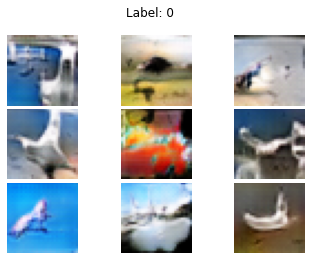

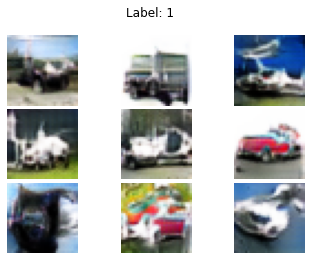

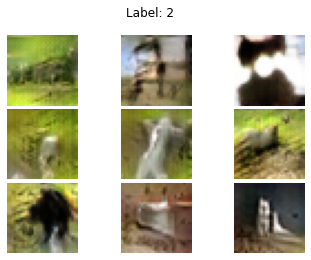

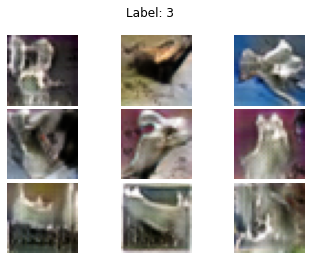

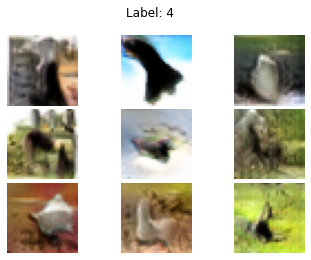

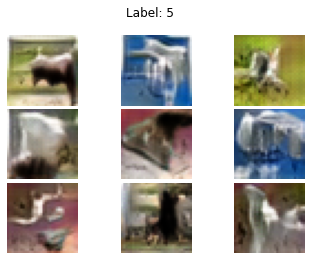

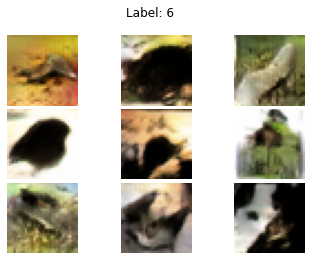

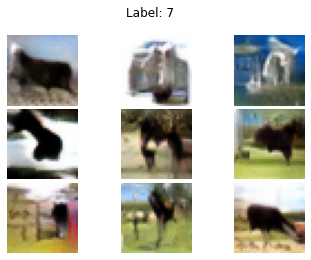

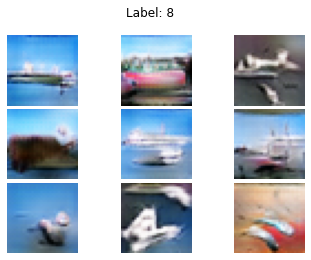

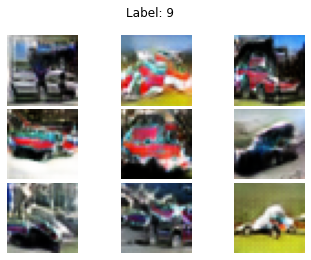

In [0]:
for classlabel in range(10):
  lbls = one_hot_encode([classlabel] * 9)
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict([noise, lbls])

  fig, axs = plt.subplots(3, 3)
  plt.subplots_adjust(hspace=0.05, wspace=0.05)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it   
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      plt.suptitle('Label: ' + str(classlabel))
      count += 1
  plt.show()
  plt.close()  